# Cabinet Member Term Length & Approval vs. Spending

The goal here is to determine if there's any relationship between the vote confirmation ratio,
the member's term length, and their spending.

## Term Length vs. Approval


Data pre-processing:

In [58]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv("../data/csv/cabinet_member_spending.csv").rename({
        "Department": "department",
        "President": "party",
        "Votes For": "votes_for",
        "Votes Against": "votes_against",
        "Days": "term_length",
        "Domestic Spending": "domestic_spending",
        "Foreign Spending": "foreign_spending"
    }, axis=1)\
    .drop(["Nominee"], axis=1)

# Correct for voice vote with 95% approval estimation
nulls = df.votes_for.isnull() & df.votes_against.isnull()
df.votes_for[nulls] = 95
df.votes_against[nulls] = 5

# Adjust party to 1 vs. -1 scale
df["party"][df.party != "Barack Obama"] = -1.0
df["party"][df.party == "Barack Obama"] = 1.0

# Add approval ratio
df["approval"] = df.votes_for / (df.votes_for + df.votes_against)

Approval vs. Term Length

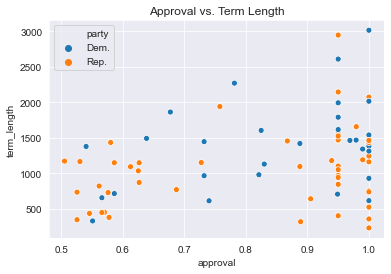

Pearson correlation coefficient: 0.340


In [70]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

plot = sns.scatterplot(x=df.approval, y=df.term_length, hue=df.party.map({-1: "Rep.", 1: "Dem."}))
plot.set_title("Approval vs. Term Length")
plt.show()

print("Pearson correlation coefficient: {:.3f}".format(df.approval.corr(df.term_length)))

Evidently there is no correlation between term length and approval... but let's see the data as a bubble plot of spending.

### All spending

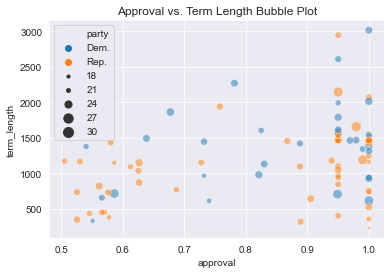

In [69]:
import numpy as np

plot = sns.scatterplot(x=df.approval,
                       y=df.term_length,
                       hue=df.party.map({-1: "Rep.", 1: "Dem."}),
                       size=np.log(df.domestic_spending + df.foreign_spending),
                       sizes=(10, 100),
                       alpha=0.5)
plot.set_title("Approval vs. Term Length: All Spending")
plt.show()

### Domestic spending

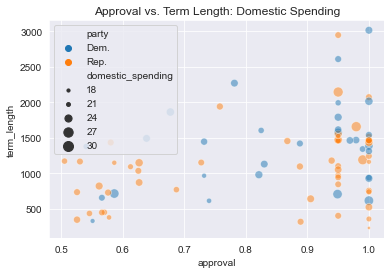

In [76]:
plot = sns.scatterplot(x=df.approval,
                       y=df.term_length,
                       hue=df.party.map({-1: "Rep.", 1: "Dem."}),
                       size=np.log(df.domestic_spending),
                       sizes=(10, 100),
                       alpha=0.5)
plot.set_title("Approval vs. Term Length: Domestic Spending")
plt.show()

# Foreign Spending

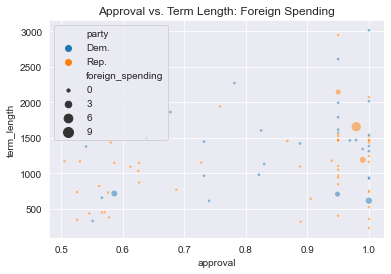

In [81]:
plot = sns.scatterplot(x=df.approval,
                       y=df.term_length,
                       hue=df.party.map({-1: "Rep.", 1: "Dem."}),
                       size=df["foreign_spending"],
                       sizes=(10, 100),
                       alpha=0.5)
plot.set_title("Approval vs. Term Length: Foreign Spending")
plt.show()

Look, polka dots! Overall there is no immediately obvious pattern in the spending, *but* it's interesting how there's not really a middle
ground. It doesn't take a clustering algorithm to point out that there's a decent cluster in the bottom left! There's
not much to be said for the entire right side though, it's all over the place in terms of term length, beyond the
fact that there are way more Republicans than Democrats in the lower-ranking term lengths.

## Spending vs. Term Length

Let's see spending vs. term length to see if there's anything interesting. The first plot is just a naive scatterplot.

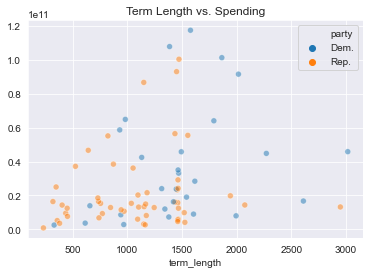

In [83]:
# ...stupid overbudgeted defense spending 
df_no_dod = df[df.department != "DEPARTMENT OF DEFENSE (DOD)"]
plot = sns.scatterplot(x=df_no_dod.term_length,
                       y=(df_no_dod.domestic_spending + df_no_dod.foreign_spending),
                       hue=df_no_dod.party.map({-1: "Rep.", 1: "Dem."}),
                       alpha=0.5)
plot.set_title("Term Length vs. Spending")
plt.show()

Most terms end sharply after ~1500 days, which *coincidentally* is about 4 years. But since you're more likely to spend
more with a longer term, this needs normalization -- $/day. I hypothesize that cabinet members who spend more $/day
have shorter terms than others.

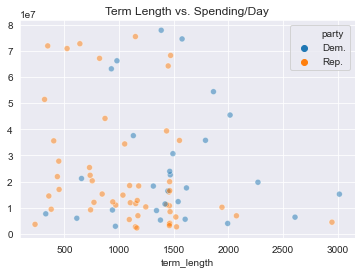

In [86]:
plot = sns.scatterplot(x=df_no_dod.term_length,
                       y=(df_no_dod.domestic_spending + df_no_dod.foreign_spending)/df_no_dod.term_length,
                       hue=df_no_dod.party.map({-1: "Rep.", 1: "Dem."}),
                       alpha=0.5)
plot.set_title("Term Length vs. Spending/Day")
plt.show()

No readily visible relationship. What about domestic $/day vs. foreign $/day?

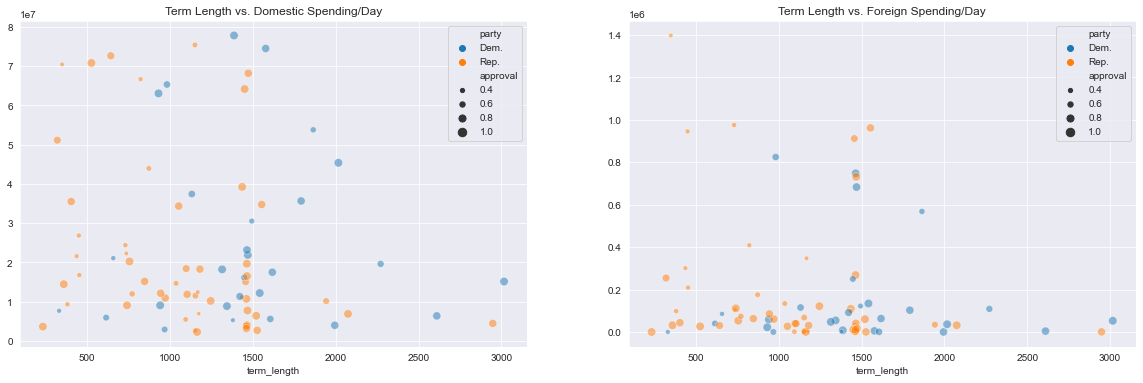

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))
plot = sns.scatterplot(x=df_no_dod.term_length,
                       y=df_no_dod.domestic_spending/df_no_dod.term_length,
                       hue=df_no_dod.party.map({-1: "Rep.", 1: "Dem."}),
                       size=df.approval,
                       alpha=0.5,
                       ax=axes[0])
plot.set_title("Term Length vs. Domestic Spending/Day")

plot = sns.scatterplot(x=df_no_dod.term_length,
                       y=df_no_dod.foreign_spending/df_no_dod.term_length,
                       hue=df_no_dod.party.map({-1: "Rep.", 1: "Dem."}),
                       size=df.approval,
                       alpha=0.5,
                       ax=axes[1])
plot.set_title("Term Length vs. Foreign Spending/Day")

plt.show()

There's no apparent relationship in either, but it is curious that there's a much wider spread of data in terms of
spending for domestic $/day vs. foriegn $/day. For another interesting data point, these dots are sized by approval.
Again, there is no relationship apparent.